# TP  Gradient projeté et gradient conditionnelle (aka Franke-Wolfe)

On cherche dans ce TP à illustrer le comportement de ces deux algos sur un prob
lème jouet

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn import datasets
from scipy.optimize import minimize_scalar
import itertools
plt.close("all")



La fonction objective que l'on cherche à optimiser est une fonction 2D
définie par sa Hessienne H, b et c.

In [4]:

def mesh(x_min,x_max,y_min,y_max, h = 0.1):
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

H = np.array([[1,-0.5],[-0.5,4]])
b = np.array([2,1])
c = 3

def cout(x):
    return 0.5*x@(H@x) + x@b + c


def cout_grad(x):
    return H@x + b

Afficher les courbes de niveau de cette fonction

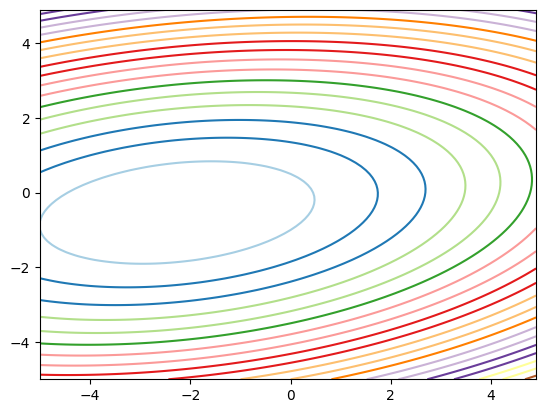

[[38.    37.955 37.92  ... 80.195 81.12  82.055]
 [36.37  36.32  36.28  ... 78.08  79.    79.93 ]
 [34.78  34.725 34.68  ... 76.005 76.92  77.845]
 ...
 [66.13  65.6   65.08  ... 61.28  61.72  62.17 ]
 [68.38  67.845 67.32  ... 63.045 63.48  63.925]
 [70.67  70.13  69.6   ... 64.85  65.28  65.72 ]]


In [18]:
# Z contient tout les points de la grille -5,5
xx, yy  = mesh(-5,5,-5,5)
Cost = np.zeros(xx.shape)

for z in itertools.product(range(len(xx)),range(len(yy))):
    Cost[z] = cout(np.array([xx[z],yy[z]]))

plt.figure(1)
plt.contour(xx, yy, Cost, 20, cmap=plt.cm.Paired)
plt.show()

print(Cost)

Affichez sur cette figure les frontieres de la contraintes suivante

1.  la courbe $\|x\|_2 = 3$

Implémenter un algorithme de gradient projété, avec un backtracking du pas, pour ces deux contraintes 
et tracer l'évolution de $w$ sur ce graphe

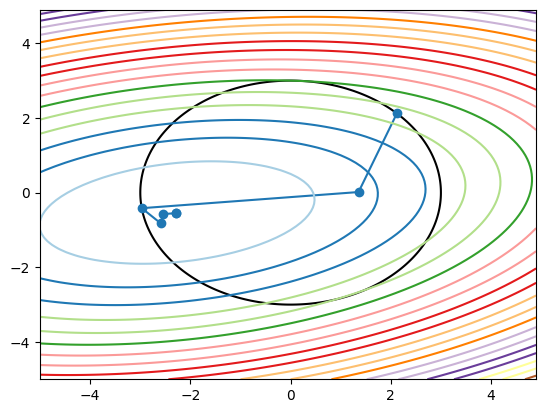

In [32]:
# inserer votre code ici

# useful functions


def projection_l2(x, tau):
    norm = np.linalg.norm(x)
    if norm <= tau:
        return x
    return tau*x/norm

def backtracking(cost, gradient, x, projection=lambda x:x , sigma_init=2, c=0.2, roo=0.5):
    dk = -gradient(x)
    f_x = cost(x)
    while cost(projection(x + sigma_init*dk)) > f_x  - c*sigma_init*dk@dk:
        sigma_init = roo*sigma_init
    return sigma_init

def get_step_function(cost, gradient, x, name='golden_search'):
    if name == 'golden_search':
        return golden_search(lambda sigma : cost(x - sigma*gradient(x)), 0, .1)
    elif name == 'backtracking':
        return backtracking(cost, gradient, x, projection=lambda x : projection_l2(x, tau=3))
    else:
        return 1e-3
    
def steepest_descent(x0,cost,gradient, projection, step_f_name="golden_search", epsilon=1e-2, maxiter=100000):
    x0 = projection(x0)
    xlist = [x0] # list of points
    flist = [cost(x0)] # list of cost function  values
    nlist = [np.linalg.norm(gradient(x0))] # list of gradient norm values
    it = 0

    x = xlist[-1]
    grad = gradient(x)
    step = get_step_function(cost, gradient, x, name=step_f_name)
    xk = x - step*grad 
    xk = projection(xk)
    xlist.append(xk)
    flist.append(cost(xk))
    nlist.append(np.linalg.norm(gradient(xk)))
    while np.abs(flist[-2] - flist[-1]) > epsilon:
        x = xlist[-1]
        grad = gradient(x)
        step = get_step_function(cost, gradient, x, name=step_f_name)
        xk = x - step*grad 
        xk = projection(xk)
        xlist.append(xk)
        flist.append(cost(xk))
        nlist.append(np.linalg.norm(gradient(xk)))
        it += 1
        if it > maxiter:
            break
    return xlist,flist,nlist


def visualize_gradient_descent(cost, gradient, xstar, x0=np.ones(2), step_f_name="backtracking", epsilon=1e-4, maxiter=100000):
    fmin  = cost(xstar)

    #grid
    ax= xstar[0]
    bx = xstar[0]
    ay= xstar[1]
    by = xstar[1]

    for test in range(2):
        #
        fig = plt.figure(1, figsize=(19,5))
        xlist,flist,nlist =  steepest_descent(x0, cost, gradient, step_f_name=step_f_name)
        xlist = np.asarray(xlist)
        #
        plt.subplot(1,3,1)
        plt.plot(xlist[:,0], xlist[:,1],'o-',label='points')
        #    #
        ax = np.min((xlist[:,0].min(),ax))-.1
        bx = np.max((xlist[:,0].max(),bx))+.1
        ay = np.min((xlist[:,1].min(),ay))-.1
        by = np.max((xlist[:,1].max(),by))+.1
        
        plt.subplot(1,3,2)
        plt.semilogy(range(len(flist)),flist-fmin+1e-16)
        plt.xlabel('iterations')
        plt.ylabel(r'$f(x^k)$')
        
        plt.subplot(1,3,3)
        plt.semilogy(nlist,':')
        plt.xlabel('iterations')
        plt.ylabel(r'$\nabla f(x^k)$')
        
        
    # 
    xgrid = np.arange(ax,bx,(bx-ax)/50)
    ygrid = np.arange(ay,by,(by-ay)/50)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i,j] = cost(np.array([X[i,j],Y[i,j]]))

    plt.subplot(1,3,1)
    plt.contour(X, Y, Z,21)

    plt.plot(xstar[0], xstar[1],'*',label='points')

tau = 3
xlist,flist,nlist =  steepest_descent(np.x(2)*4, cout, cout_grad, projection=lambda x : projection_l2(x, tau=tau), step_f_name="backtracking")

xlist = np.asarray(xlist)
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de z
Z = X**2 + Y**2

# Créer le plot de contour pour le cercle de rayon 3
plt.contour(X, Y, Z, levels=[9], colors='black')
plt.plot(xlist[:,0], xlist[:,1],'o-',label='points')
plt.contour(xx, yy, Cost, 20, cmap=plt.cm.Paired)
plt.show()

In [33]:

# nb_iter = 100
# w = np.random.randn(2)*3
# m_cout = np.zeros(nb_iter)
# mat_w = np.zeros((nb_iter,2))
# beta = 0.9
# c = 0.5
# tho = 1
# for i in range(nb_iter):    
#   # inserer votre code ici
  
  
# plt.plot(mat_w[:,0],mat_w[:,1],'r')

# Algorithme de Franke-Wolfe

On cherche à apprendre un modèle de régression sous contrainte de norme $\ell_1$. On cherche
donc à résoudre le probleme
$$
\min_w \frac{1}{2} \|y - Xw\|_2^2  \quad \text{sc} \quad \|w\|_1 \leq \tau
$$

en sachant que 
$$
z = \arg\min_z a^\top z \quad \|w\|_1 \leq \tau
$$
avec $z = -\tau sign(a_k) e_{i_k}$ et $i_k = \arg\max_k |a_k|$


1.   Implémenter l'algorithme de Franke-wolfe correspondant
2.   Appliquer cette algorithme aux données diabetes du TP de regression de ML.
3.   Analyser la forme du minimiseur en fonction de $\tau$
4.   Commenter la solution





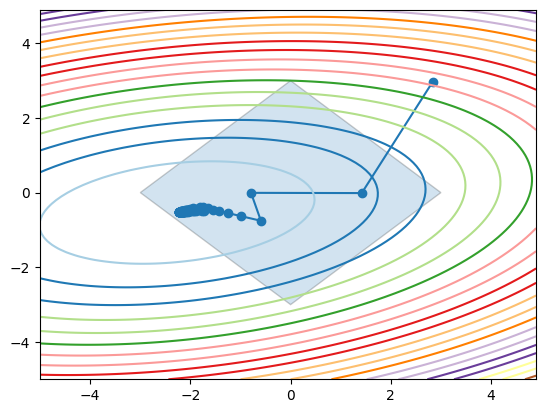

In [23]:

    
# inserer votre code

def frank_wolf(x0, gradiant, step_f_name="backtracking", epsilon=1e-4, maxiter=100):
    d = x0.shape[0]
    w = np.random.rand(d)*0.04
    m_cout = np.zeros(maxiter)
    tau = 3
    e = np.zeros(d)

    k = 1 

    xlist = [x0]
    x = xlist[-1]    
    z = np.zeros(d)
    c = gradiant(x)
    i = np.argmax(np.abs(c))
    z[i] = -tau*np.sign(c[i])
    alpha = 1/(k*2)
    alpha = 1/(2*k)
    xk = (1 - alpha)*x + alpha*z
    xlist.append(xk)
    while np.linalg.norm(xlist[-2] - xlist[-1]) > epsilon and k <= maxiter:
        x = xlist[-1]    
        z = np.zeros(d)
        c = gradiant(x)
        i = np.argmax(np.abs(c))
        z[i] = -tau*np.sign(c[i])
        alpha = 1/(k*2)
        alpha = 1/(2*k)
        xk = (1 - alpha)*x + alpha*z
        xlist.append(xk)
        k+= 1
    return xlist



x0 = np.random.rand(2)*3
xlist = frank_wolf(x0, cout_grad)

xlist = np.asarray(xlist)
xx, yy  = mesh(-5,5,-5,5)
Cost = np.zeros(xx.shape)

for z in itertools.product(range(len(xx)),range(len(yy))):
    Cost[z] = cout(np.array([xx[z],yy[z]]))


fig , ax = plt.subplots()
points = [[0, 3], [3, 0], [0, -3], [-3, 0]]
polygon= Polygon(points, closed=True, alpha=0.2, edgecolor='black')
ax.add_patch(polygon)

plt.plot(xlist[:,0], xlist[:,1],'o-',label='points')
# plt.contour(X, Y, Z, levels=[9], colors='black')
plt.contour(xx, yy, Cost, 20, cmap=plt.cm.Paired)
plt.show()

In [37]:
data = 'diabetes'

if data == 'boston':
    data = datasets.load_boston(True)
else:
    data = datasets.load_diabetes()

X = data['data']
y = data['target']



((442, 10), (442,))

In [41]:


#------------------------
d = X.shape[1]
nb_iter = 100
w = np.random.rand(d)*0.04
m_cout = np.zeros(nb_iter)
tau = 3

cout_grad = lambda w : X.T@(X@w - y)
# xlist = frank_wolf(w, )


xlist =  frank_wolf(w, cout_grad)


print(xlist[-1])

[1.06135702e-03 3.52865697e-04 2.91589927e+00 5.99740574e-04
 5.18401212e-05 6.70995668e-04 2.48167298e-04 2.28555401e-04
 7.28658397e-04 1.73143342e-04]
